# ParagonCorp Quantity Sales Forecast using Multiple Time Series Models

## This Notebook is created by Prayoga Agusto Haradi for the creation of the final project in Hacktiv8 

## Background

Time series forecasting models are necessary to predict future values for a product's item quantity sales because they provide valuable insights for businesses to make data-driven decisions. Accurate demand forecasts are essential for effective inventory management, as they help estimate the quantity of products needed to meet future demand. This not only prevents stockouts but also reduces excess inventory and optimizes supply chain operations. 

Furthermore, these models support better resource allocation by informing staffing and production schedules, thereby improving overall efficiency. Forecasting models also enable businesses to identify trends, seasonality, and patterns in sales data, which can inform marketing strategies and promotions. In summary, time series forecasting models play a crucial role in helping businesses make informed decisions, optimize operations, and stay competitive in the marketplace.

## Objective

The objective of this project is to develop and compare multiple time series forecasting models, including LSTM, NeuralProphet, and SARIMA, to accurately predict future product sales for a specific item. By leveraging the strengths of these diverse models, we will be able to provide reliable and accurate forecasts to help our company make data-driven decisions, optimize operations, and stay competitive in the marketplace.

By comparing the performance of these models, we seek to identify the most suitable approach for forecasting product sales in this specific context. The insights gained from these forecasts will enable our company to optimize inventory management, allocate resources efficiently, and identify trends, seasonality, and patterns in sales data to inform marketing strategies and promotions. In essence, this project aims to empower our company with accurate sales forecasts, ultimately leading to improved operational efficiency and competitiveness in the marketplace.

## Dataset

The dataset originates from ParagonCorp's dataset where it consists of the following columns:

- week_number: contained information about week of specific product sold, (2021-52 to 2023-14).
- week_start_date: contained information about week start date of specific product sold.
- week_end_date: contained information about week end date of specific product sold.
- product_item: contained information about product item/product code (Variabel Bebas).
- quantity: contained information about quantity of product in respective week.

Using these columns, we will be doing a time series analysis, and then we will make a couple of models to predict and forecast quantity amount in the foreseeable future.

## Import Library

We will be importing the following libraries.

In [4]:
# Importing required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
# fix random seed for reproducibility
np.random.seed(7)
import warnings
warnings.filterwarnings("ignore")

## Data Loading

Load the data using pd.read_csv

In [5]:
df = pd.read_csv('sample_dataset_timeseries_noarea.csv')
df.head()

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [6]:
df.tail()

,week_number,week_start_date,week_end_date,product_item,quantity
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


## Exploratory Data Analysis

We will use df.info() to see if the datatype for each column and to see if there are any missing values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


We can see that there is 2 missing values in the product_item column.

In [8]:
df.loc[df['product_item'].isnull()]

,week_number,week_start_date,week_end_date,product_item,quantity
18048,2022-12,2022-03-21,2022-03-27,NaN,119
19536,2022-13,2022-03-28,2022-04-03,NaN,147


Because we can't know what the NaN product_item are for this data and that there are only 2 data that is missing, we will drop it instead using dropna()

In [9]:
df = df.dropna()

Next, we will see all of the unique products that are in this dataset.

In [10]:
df['product_item'].nunique()

2309

Based on the code above, we can see that there are around 2309 products that are listed in this dataset.

For my project, I will only be predicting and forecasting the time series just for one product using multiple models. For this case, i will be using the product with the product_item id 'ffbd6f1d884056a4f622d54ae79e5a14'

In [11]:
prod_count = df[df['product_item'] == 'ffbd6f1d884056a4f622d54ae79e5a14']

In [12]:
prod_count.describe()

,quantity
count,67.000000
mean,52729.850746
std,21190.375686
min,537.000000
25%,45583.000000
50%,50193.000000
75%,61413.500000
max,112978.000000


Based on the descriptive statistics above, we can infer that:
1. There are 67 data points in the dataset, representing 67 weeks of observations for our selected product.
2. The mean (average) quantity for the dataset is 52,729.85, suggesting that on average, there are around 52,730 units per week.
3. The standard deviation is 21,190.38, which indicates a considerable variation in the quantity from week to week. This means the data has fluctuations and is not stable around the mean.
4. The minimum quantity is 537, and the maximum quantity is 112,978. This wide range suggests that there could be some weeks with very low or very high quantities, which may be due to seasonality or other external factors.

In [13]:
prod_count['week_end_date'] = pd.to_datetime(prod_count.loc[:,'week_end_date'])

In [14]:
prod_count = prod_count[['week_end_date','quantity']]
prod_test = prod_count[['quantity']]

In [15]:
prod_count['week_end_date']

449      2022-01-02
1948     2022-01-09
3425     2022-01-16
4905     2022-01-23
6376     2022-01-30
            ...    
96735    2023-03-12
98236    2023-03-19
99716    2023-03-26
101231   2023-04-02
102731   2023-04-09
Name: week_end_date, Length: 67, dtype: datetime64[ns]

We can see that our data spans 67 week, starting from 2 January 2022 all the way to 9 April 2023.

#### Trend Line Visualization

Afterwards, we will visualize the quantity of our product from said time span and see if there are any trends or seasonality that can be seen directly.

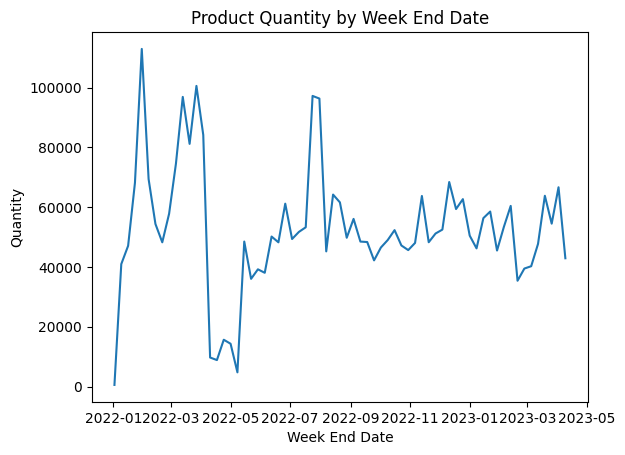

In [16]:
plt.plot(prod_count['week_end_date'], prod_count['quantity'])
plt.xlabel('Week End Date')
plt.ylabel('Quantity')
plt.title('Product Quantity by Week End Date')
plt.show()

We can see from the above visualization, that our data starts with a very low amount of quantity sales, before ramping up in the next few weeks. Once the date reaches April 10 2022, the product sales dip massively for 4 weeks, before increasing again and stabilizing around the mean (52.769) for the rest of the week.

The first data point having a very low quantity sales could be because of the product being launched at the very same week, which means the product doesn't have enough traction yet. After a couple weeks, the quantity sales jump massively for around 10 weeks which could correspond with product campaigns resulting in a sales increase, before the campaign is ended and the sales drops massively for 4 weeks.

After those 4 weeks of low sales have passed, the quantity sales stabilizes again around the mean with a random pattern signifying that the product may have established their market presence and are experiencing steady demand, with sales being consistent and the early product campaign managed to give traction to the customers that this product is aimed for. 

#### Adfuller Test (Checking Trend)

We will do the Adfuller test to check if our data has a trend that needs to be addressed first or in other words, if our data is non-stationary.

In [14]:
def adfuller_test(quantity):
    
    result=adfuller(quantity)
    
    labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [15]:
X = prod_count['quantity']
result = adfuller_test(X)

ADF Test Statistic : -4.69862745002056
p-value : 8.465380666555452e-05
Lags Used : 0
Number of Observations Used : 66
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Based on the adfuller test above, we can conclude that our data has no visible trends and hence is considered a stationary data. However, we still need to check if our data has a seasonality factor that we need to address.

#### ACF and PACF Plot

Next, we will plot the ACF and PACF plot of our time series data. 

The ACF measures the correlation between a time series and its lagged version (i.e., the same time series shifted by a certain number of time steps). It helps identify the presence of autocorrelation in the data, which means that the value at a given time point is influenced by the values at previous time points. Whereas the PACF measures the correlation between a time series and its lagged version after removing the effect of correlations at shorter lags. 

Both ACF and PACF plots are essential in creating a time series model, especially for selecting the appropriate parameters for Autoregressive Integrated Moving Average (ARIMA) models and their variations, such as Seasonal ARIMA (SARIMA). These plots help to identify the order of the autoregressive (AR) and moving average (MA) components in the model by showing the significant lags in the data. 

The ACF and PACF plots can also be used to detect the seasonality cycle of our data by detecting a high correlation for a certain cycle (e.g 12,24 for yearly seasonality).

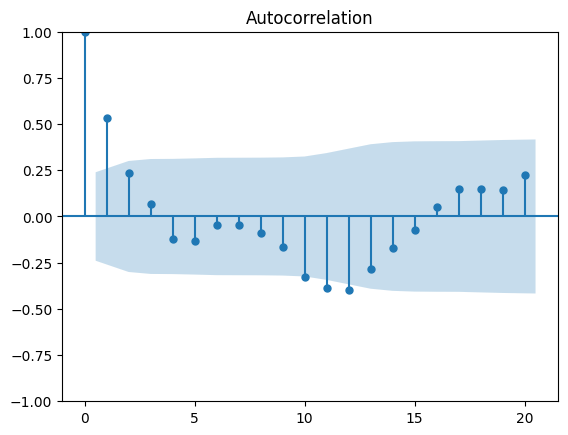

In [16]:
plot_acf(prod_test,lags=20)
plt.show()

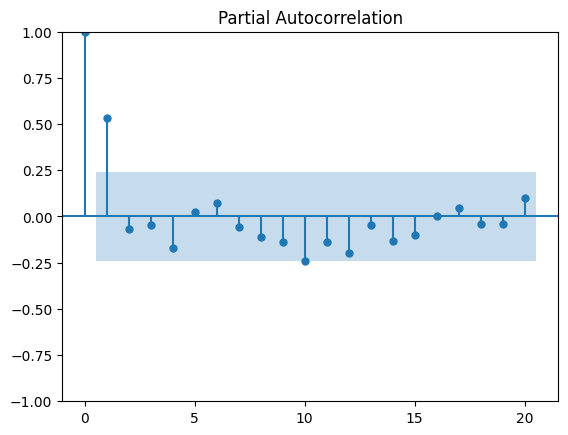

In [17]:
plot_pacf(prod_test,method='ywm',lags=20)
plt.show()

Based on the ACF plot above, we can see that there seems to be a seasonality cycle for every 10 weeks. We can also determine the order of p and q (for AR and MA respectively) in an ARMA model. Where for our case, the AR order is 3 (based on PACF where the y value is close to 0), and the MA order is 3 (based on ACF where the y value is close to 0).

Afterwards, we will try removing the seasonality cycle by differentiating using the shift function for around 10 data(because that is the cycle of our seasonality). 

In [18]:
prod_test = prod_count.set_index('week_end_date')

In [19]:
# remove seasonal component
diff = prod_test - prod_test.shift(1)
seasonal_diff = diff - diff.shift(10)
seasonal_diff = seasonal_diff.dropna(inplace=False)

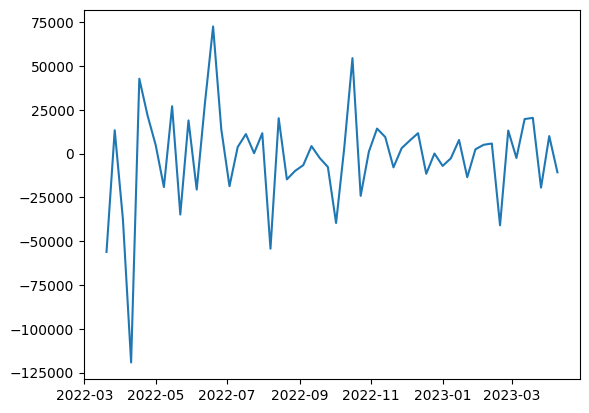

In [20]:
plt.plot(seasonal_diff)

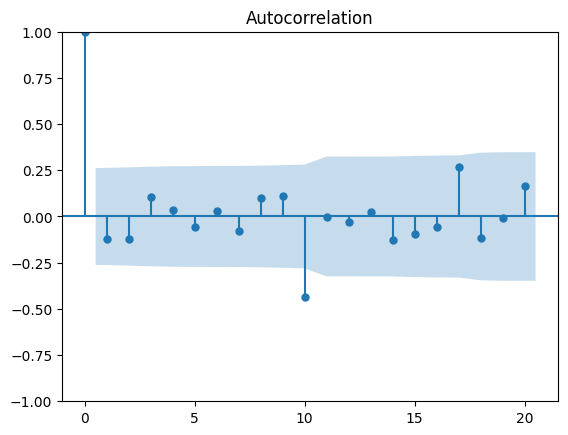

In [21]:
plot_acf(seasonal_diff,lags=20)
plt.show()

We can see from above, that the data seems to be more randomized and no visual representation of trend and seasonality, and the Autocorrelation drops to a stable value quicker than before. We can also conclude that our seasonality is an additive seasonality due to the variations being relatively the same for each cycle.

#### Seasonal Decomposition

To make the trend and seasonality visualization even more clear, we can use seasonal_decompose from the statsmodel module to visualize it.

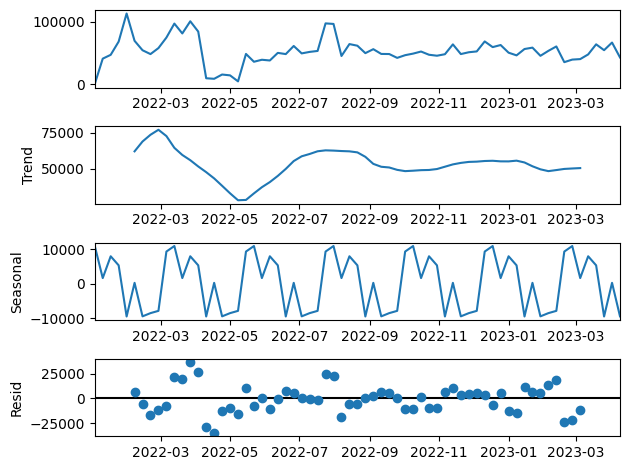

In [22]:
decomposition = sm.tsa.seasonal_decompose(prod_test, model='additive',period=10)
fig = decomposition.plot()
plt.show()

We can see from the visualization above, the trend increased until it reaches the max value and the dips down to the lowest before stabilizing in the middle, which represents that our data is stationary once the product have reached their intended market segment.

We can also see the seasonality seems to have a visualization that constantly goes to the top, before slowly dropping down after a couple of weeks until the seasonality repeats itself after the 10th week.

#### EDA Conclusion

Based on the EDA that we have done, we can conclude these following points:

1. Our data starts with a very low quantity sales before reaching the peak amount of sales after a few weeks, and then it drops down to a low amount of sales before stabilizing with sales near the mean amount. Which means that once the first few months have passed, our product have managed to create a stable market demand and have found the market segment our product is intended for.

2. There seems to be a seasonality cycle of 10 weeks.

3. Our data is stationary (no trend) based on the adfuller test and visualization.

## Data Preprocessing

For this case, we will be using 3 different models to predict and forecast our time series. The models are SARIMA, LSTM Neural Network, and NeuralProphet from Meta (Facebook). But before we get into the modelling, we need to preprocess the data for each model, because each of these models have different requirements before it can predict our time series.

#### Preprocessing for NeuralProphet

In [23]:
neural_data = prod_count[['week_end_date', 'quantity']].copy()
neural_data.dropna(inplace=True)
neural_data.columns = ['ds', 'y'] 
neural_data.head()

,ds,y
449,2022-01-02,537
1948,2022-01-09,40975
3425,2022-01-16,47080
4905,2022-01-23,68171
6376,2022-01-30,112978


In [24]:
train_ratio = 0.85
train_end = int(train_ratio * len(neural_data))
neural_train_data = neural_data[:train_end]
neural_test_data = neural_data[train_end:]

For NeuralProphet, our date needs to be in a column named 'ds' and our target variable (quantity) needs to be in a column named 'y'

#### Preprocessing for LSTM

In [25]:
lstm_data = prod_count.copy()

In [26]:
# Scale the prod_count
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data["scaled_quantity"] = scaler.fit_transform(lstm_data[["quantity"]])

In [27]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# Calculate the indices for splitting the data
train_end = int(train_ratio * len(lstm_data))
validation_end = int((train_ratio + validation_ratio) * len(lstm_data))

# Split the data
lstm_train_data = lstm_data[:train_end]
lstm_validation_data = lstm_data[train_end:validation_end]
lstm_test_data = lstm_data[validation_end:]

In [28]:
def create_input_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [29]:
window_size = 4  # Define a suitable window size based on your data
X_train, y_train = create_input_sequences(lstm_train_data["scaled_quantity"].values, window_size)
X_validation, y_validation = create_input_sequences(lstm_validation_data["scaled_quantity"].values, window_size)
X_test, y_test = create_input_sequences(lstm_test_data["scaled_quantity"].values, window_size)

In [30]:
# Reshape data into 3D format (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

For LSTM, the method for preprocessing the data is significantly different compared to the other 2 models. Since LSTM only accepts inputs with a 3D format, we need to convert our data into a tensor using the above code. LSTM also needs the data to be scaled using minmaxscaler or any other scaling methods in order to give accurate predictions.

#### Preprocessing for SARIMA

In [31]:
data = prod_count.set_index('week_end_date')

In [32]:
data

,quantity
week_end_date,
2022-01-02,537
2022-01-09,40975
2022-01-16,47080
2022-01-23,68171
2022-01-30,112978
...,...
2023-03-12,47735
2023-03-19,63840
2023-03-26,54501


In [33]:
# Split the data into train and test sets
train_ratio = 0.85
train_end = int(train_ratio * len(data))
train_data = data[:train_end]
test_data = data[train_end:]

Preprocessing for SARIMA just requires the data to be split into train and testing data.

## Model Definition & Training

### NeuralProphet Modelling

NeuralProphet is a modern time series forecasting library that extends the popular Prophet model from Facebook (Meta) with deep learning techniques. It combines the strengths of the original Prophet model (such as automatic trend and seasonality detection, handling of missing data, and robustness to outliers) with the flexibility and power of deep learning. NeuralProphet offers various components, such as autoregression (AR), trend, seasonality, and special events, which can be combined to create a custom forecasting model. The AR component can use either a linear regression model or a more complex neural network architecture, allowing for more expressive models and improved performance on a wide range of time series data.

For our NeuralProphet model, we will be using the parameters below to predict our test data and evaluate the accuracy of our model. The parameters below are the ones that I have currently found to be the most optimal for this case.

In [34]:
m = NeuralProphet(batch_size=128,learning_rate=0.1,n_lags=1,
                  num_hidden_layers=3,d_hidden=64,seasonality_mode='additive')

Our seasonality is additive from our previous visualization, and our model will have a learning rate of 0.1 with 1 number of lags. The neural network will have 3 hidden layer with 64 hidden units.

In [35]:
m.add_seasonality(period=10, fourier_order=7, name='10 Weeks')

We will add a seasonality with period of 10 weeks

In [36]:
neural_model = m.fit(neural_train_data, freq='W', epochs=500)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.214% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


Training: 0it [00:00, ?it/s]

We then fit our NeuralProphet model using 500 epochs with the freq set to weekly.

In [37]:
neural_model

,MAE,RMSE,Loss,RegLoss,epoch
0,148887.093750,172125.515625,0.888804,0.0,0
1,123208.554688,146289.468750,0.697399,0.0,1
2,100839.820312,122930.476562,0.533121,0.0,2
3,84384.273438,102772.859375,0.398109,0.0,3
4,73119.203125,87599.437500,0.301083,0.0,4
...,...,...,...,...,...
495,8013.605469,11901.152344,0.004923,0.0,495
496,8013.625977,11901.073242,0.004923,0.0,496
497,8013.634277,11901.003906,0.004922,0.0,497
498,8013.638184,11900.966797,0.004922,0.0,498


As we can see from the above data, our model has 9320 MAE during fitting using our training data. This value will be compared to the test set value to see if our data is overfitting or not.

In [38]:
future = m.make_future_dataframe(neural_data, periods=10,n_historic_predictions=len(neural_data))
forecast = m.predict(future)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.507% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (NP.forecaster._make_future_dataframe) - Insufficient data for 67 historic forecasts, reduced to 66.
WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.529% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 98.529% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


Predicting: 1it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,ar1,trend,season_10 Weeks
0,2022-01-02,537.0,NaN,NaN,NaN,NaN
1,2022-01-09,40975.0,42483.484375,-45507.859375,89078.351562,-1087.002319
2,2022-01-16,47080.0,54684.250000,-38204.085938,89333.304688,3555.035645
3,2022-01-23,68171.0,64287.179688,-25722.189453,89588.250000,421.120911
4,2022-01-30,112978.0,77811.078125,-7396.978027,89843.195312,-4635.143555
...,...,...,...,...,...,...
63,2023-03-19,63840.0,55588.234375,-25561.576172,80728.695312,421.120911
64,2023-03-26,54501.0,57033.812500,-19328.816406,80997.773438,-4635.143555
65,2023-04-02,66679.0,61887.421875,-23943.753906,81266.859375,4564.323730
66,2023-04-09,42920.0,58836.433594,-11441.880859,81535.937500,-11257.625000


The code above is to predict the values on our test data for evaluation.

### LSTM Neural Network Modelling

For our LSTM model, we will be using Bidirectional LSTM instead of the regular LSTM. Why should we use Bidirectional LSTM compared to LSTM?

Bidirectional LSTMs can sometimes perform better than regular LSTMs for time series data because they process the input data in both forward and backward directions, allowing our model to capture information from both past and future time steps. This can be beneficial when there is a strong dependency between time steps or when the future context can help improve predictions.

In a regular LSTM, the model processes the input data in a single direction, typically from the past to the future. This means that it can only learn from past information and can be limited in its ability to capture patterns that depend on future context.

In contrast, a Bidirectional LSTM processes the input data in both directions, using two separate LSTM layers – one for the forward direction and one for the backward direction. The outputs of these two layers are then combined, allowing the model to learn from both past and future information.

For some time series tasks, the bidirectional approach can lead to improved performance, as the model can more effectively capture complex patterns and relationships in the data. However,  Bidirectional LSTMs are more computationally expensive than regular LSTMs due to the additional layer and the need to process the data in both directions. Which means there is a trade-off between the potential for improved performance and the increased computational requirements.

In [39]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=100, return_sequences=True, activation='tanh')))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=100, return_sequences=True, activation='tanh')))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=100, return_sequences=False, activation='tanh')))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [40]:
# Compile the model
model.compile(optimizer="adam", loss="mean_absolute_error",metrics=['mae'])

We will be using 4 layers of Bidirectional LSTM with 100 units each and an activation function using tanh, with each layer having a Dropout layer to prevent overfitting. The final layer will be the output layer Dense with 1 output. 

Model will be compiled using adam optimizer with the loss function "mean_absolute_error" and the metrics "mae"

We will also be using 100 epochs with a batch size of 32 during the fitting with cross validation using our validation data.

In [41]:
epochs = 100
batch_size = 32
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_validation, y_validation),
    verbose=1,
)

Epoch 1/100
2/2 [==============================] - 14s 2s/step - loss: 0.4667 - mae: 0.4667 - val_loss: 0.4119 - val_mae: 0.4119
Epoch 2/100
2/2 [==============================] - 0s 68ms/step - loss: 0.3901 - mae: 0.3901 - val_loss: 0.2795 - val_mae: 0.2795
Epoch 3/100
2/2 [==============================] - 0s 66ms/step - loss: 0.2828 - mae: 0.2828 - val_loss: 0.0582 - val_mae: 0.0582
Epoch 4/100
2/2 [==============================] - 0s 71ms/step - loss: 0.1504 - mae: 0.1504 - val_loss: 0.1867 - val_mae: 0.1867
Epoch 5/100
2/2 [==============================] - 0s 64ms/step - loss: 0.2204 - mae: 0.2204 - val_loss: 0.0487 - val_mae: 0.0487
Epoch 6/100
2/2 [==============================] - 0s 63ms/step - loss: 0.1438 - mae: 0.1438 - val_loss: 0.1277 - val_mae: 0.1277
Epoch 7/100
2/2 [==============================] - 0s 62ms/step - loss: 0.1906 - mae: 0.1906 - val_loss: 0.1698 - val_mae: 0.1698
Epoch 8/100
2/2 [==============================] - 0s 54ms/step - loss: 0.2112 - mae: 0.211

### SARIMA Modelling

The last model we will be using is the SARIMA model. 

SARIMA (Seasonal Autoregressive Integrated Moving Average) is a widely used statistical method for time series forecasting. It combines the ARIMA (Autoregressive Integrated Moving Average) model with a seasonal component to capture both non-seasonal and seasonal patterns in the data. The model consists of three components: autoregression (AR), differencing (I), and moving average (MA), each with their respective parameters (p, d, q) for non-seasonal data and seasonal parameters (P, D, Q) with a seasonal period (s) for seasonal data.

Since our data has a seasonality that can also be a factor in predicting our future values, we will be using SARIMA instead of ARIMA.

In [42]:
order =  (3,0,3)
seasonal_order = (3, 0, 3, 10)

Based on the PACF and ACF plot as well as our seasonality decomposition, we will be using the above order and seasonal order for our SARIMA model. These values for our SARIMA model are the values that gives the lowest MAE for our SARIMA model from my personal exploration.

In [43]:
# Train the SARIMA model
sarima_model = SARIMAX(train_data["quantity"], order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

In [44]:
# Predict values for the test set using SARIMA
sarima_pred = sarima_results.get_forecast(steps=len(test_data))
sarima_pred_values = sarima_pred.predicted_mean

We fit the model using the preprocessed train data and we predict our values in the test data in order to evaluate the accuracy of our model.

Before we evaluate our models, it would be best to know the advantages and disadvantages of each model to be able to interpret on why one of these models will be better than the other models:

1. SARIMA:
- Advantages:

    - Effectively models linear relationships, seasonality, and trends in the data.
    - Interpretable model parameters help in understanding the underlying patterns in the data.
    -  Relatively simple and easy to implement.
    - Requires fewer computational resources compared to deep learning models.

- Disadvantages:
    - Assumes data is stationary or can be made stationary through differencing, which may not always be the case.
    - May not perform well with complex, nonlinear relationships in the data.
    - Requires manual selection or grid search for optimal model parameters.

2. LSTM:
- Advantages:

    - Capable of modeling complex, nonlinear relationships in the data.
    - Can handle long-term dependencies in time series data through memory cells.
    - Flexible architecture that can be combined with other deep learning techniques (e.g., CNNs) for better performance.

- Disadvantages:

    - Requires significant computational resources and longer training times.
    - May suffer from overfitting.
    - Model interpretability is limited, making it difficult to understand the underlying patterns in the data.

3. NeuralProphet:
- Advantages:

    - Combines traditional time series models (e.g., ARIMA) with neural networks for improved forecasting performance.
    - Can model nonlinear relationships, seasonality, and trends.
    - Offers a user-friendly interface and easy-to-use API.
    - Automatically selects model components and can be extended with custom components.
    .

- Disadvantages:

    - Relatively new model with less community support compared to other well-established models.
    - Requires more computational resources than traditional models like SARIMA.
    - Model interpretability is limited compared to traditional models.

## Model Evaluation

#### NeuralProphet

For NeuralProphet evaluation, we can use the forecast variable that we have defined from neuralprophet to see our prediction data and its comparison against the test data.

In [47]:
forecast_pred = forecast[['yhat1']]

In [48]:
predictions = forecast_pred[56:67]

In [49]:
testing = test_data[['quantity']].reset_index()
preds = predictions[['yhat1']].reset_index()

In [50]:
residuals = testing['quantity'] - preds['yhat1']

In [51]:
testing = testing.set_index('week_end_date')

Text(0, 0.5, 'Error')

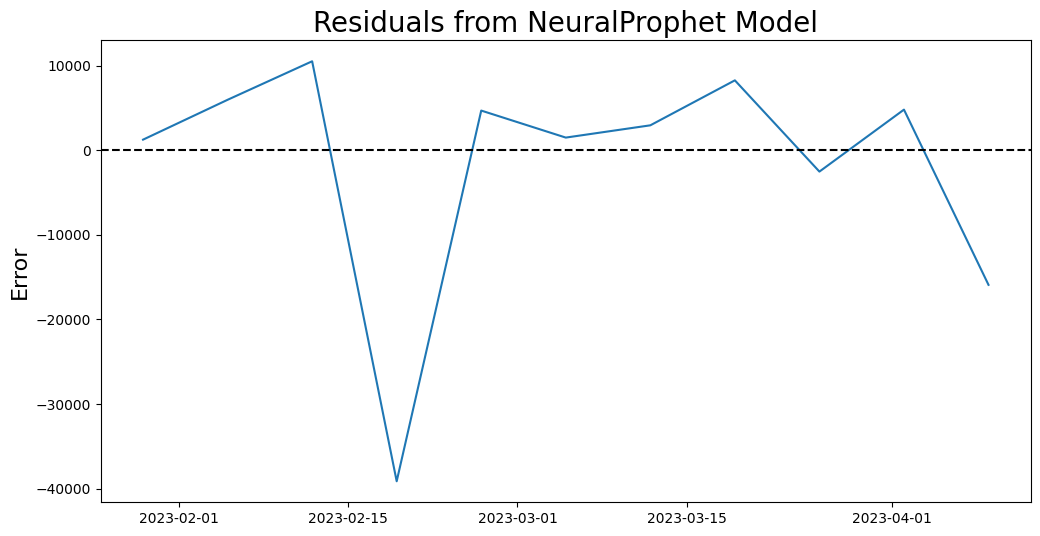

In [52]:
plt.figure(figsize=(12,6))
plt.plot(testing.index,residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from NeuralProphet Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

The above plot functions to plot the residuals from the NeuralProphet model, residuals are the difference in error between our test data and the predicted values of the model, where a negative score means that our predicted model has a higher value than the test set, and a positive score means that our predicted model has a lower value than the test set. We can see that the model has a tendency to over-value our quantity model compared to under-valuing it. 

In [53]:
# Calculate the mean absolute error for the neuralprophet predictions
neural_prophet_mae = mean_absolute_error(testing['quantity'], preds['yhat1'])
neural_prophet_mape = mean_absolute_percentage_error(testing['quantity'], preds['yhat1'])
print(f"NeuralProphet Mean Absolute Error: {neural_prophet_mae}")
print(f"NeuralProphet Mean Absolute Percentage Error: {neural_prophet_mape*100}","%")

NeuralProphet Mean Absolute Error: 8856.84765625
NeuralProphet Mean Absolute Percentage Error: 20.48436560025533 %


From the metrics above, we can see that our errors are around 20.4% with an average MAE of 8856 quantity sales

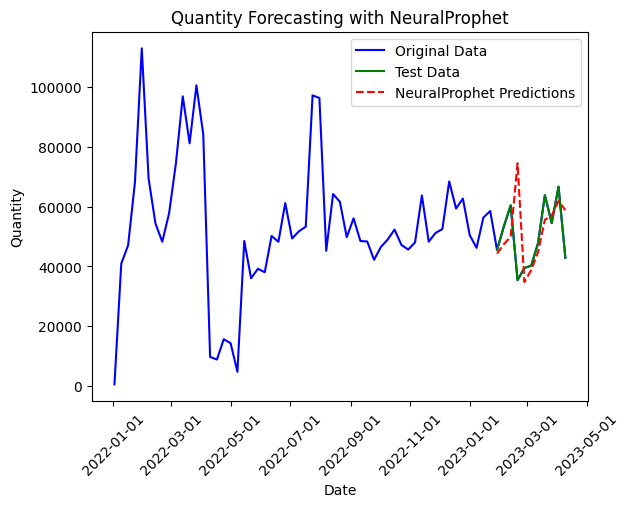

In [54]:
# Convert the index of data to datetime objects
date_index = data.index

# Plot the original data
plt.plot(date_index, data["quantity"], label="Original Data", color="blue")

# Plot the test data
test_start = len(train_data)
test_end = len(data)
plt.plot(date_index[test_start:], test_data["quantity"], label="Test Data", color="green")

# Plot the NeuralProphet predictions
plt.plot(date_index[test_start:], predictions['yhat1'], label="NeuralProphet Predictions", color="red", linestyle="--")

# Customize the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Added to fix the x-axis date ticks
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Quantity Forecasting with NeuralProphet")
plt.legend()
plt.show()

And the above visualization functions to plot the difference between our test data and the predictions. As we can see, our model has a tendency to over-value our quantity sales which was also seen in the residual visualization. It managed to catched the seasonality trend of our data, but it still has trouble in understanding it fully

#### LSTM

In [55]:
# Predict values for the test set
y_pred = model.predict(X_test)

# Reverse the scaling to get the actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [56]:
lstm_mae = mean_absolute_error(y_test_actual, y_pred_actual)
lstm_mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
print(f"LSTM Mean Absolute Error: {lstm_mae}")
print(f"LSTM Mean Absolute Percentage Error: {lstm_mape*100}","%")

LSTM Mean Absolute Error: 9434.677455357143
LSTM Mean Absolute Percentage Error: 17.579643233457958 %


Our Bidirectional LSTM model have MAPE score of 17.5% with a MAE of 9434.9. This is significantly better compared to our NeuralProphet model.

In [57]:
test_data["quantity"][4:].shape

(7,)

In [58]:
y_pred_actual = y_pred_actual.flatten()

In [59]:
lstm_residuals = test_data["quantity"][4:] - y_pred_actual

Text(0, 0.5, 'Error')

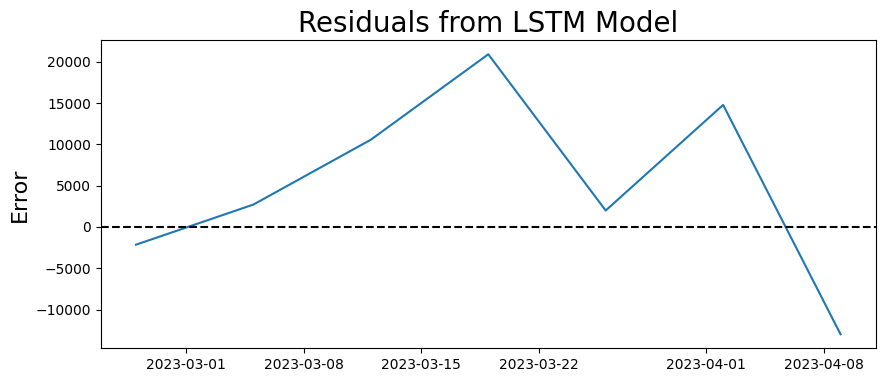

In [60]:
plt.figure(figsize=(10,4))
plt.plot(lstm_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from LSTM Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Based on the residual visualization above, we can see that the LSTM model seem to have the tendency to under-value our test data compared to over-valuing it.

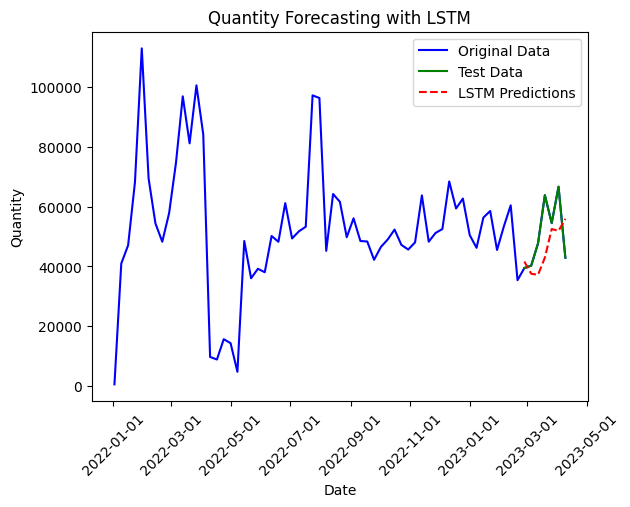

In [61]:
# Convert the index of data to datetime objects
date_index = data.index

# Plot the original data
plt.plot(date_index, data["quantity"], label="Original Data", color="blue")

# Plot the test data
test_start = len(train_data)
test_end = len(data)
plt.plot(date_index[test_start:][4:], test_data["quantity"][4:], label="Test Data", color="green")

# Plot the LSTM predictions
plt.plot(date_index[test_start:][4:], y_pred_actual, label="LSTM Predictions", color="red", linestyle="--")

# Customize the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Added to fix the x-axis date ticks
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Quantity Forecasting with LSTM")
plt.legend()
plt.show()

The forecasting above shows how our prediction seem to show that our model also managed to get the seasonality factor of our original dataset. However, just like the NeuralProphet model, it also has trouble in understanding the patterns of our data.

#### SARIMA

In [62]:
# Calculate the mean absolute error for the SARIMA predictions
sarima_mae = mean_absolute_error(test_data, sarima_pred_values)
sarima_mape = mean_absolute_percentage_error(test_data, sarima_pred_values)
print(f"SARIMA Mean Absolute Error: {sarima_mae}")
print(f"SARIMA Mean Absolute Percentage Error: {sarima_mape*100}","%")

SARIMA Mean Absolute Error: 7510.290886043071
SARIMA Mean Absolute Percentage Error: 15.250196958841562 %


The MAE and MAPE of our SARIMA model is the lowest of all the models that we tested with a MAE score of 7510 and a MAPE score of 15.25%. This value suggests that our SARIMA model managed to grasp the pattern and the seasonality of our data better than the other 2 models.

In [63]:
test_data_2 = test_data['quantity'].reset_index()

In [64]:
sarima_pred_values_2 = sarima_pred_values.reset_index()

In [65]:
sarima_residuals = test_data_2['quantity'] - sarima_pred_values_2['predicted_mean']

In [66]:
sarima_residuals

0    -15769.498278
1     -7486.690006
2       -41.629728
3     -2495.514788
4     -2933.224749
5    -13416.815247
6     -2960.273256
7     14353.624471
8     -1061.721215
9     13123.659621
10    -8970.548387
dtype: float64

Text(0, 0.5, 'Error')

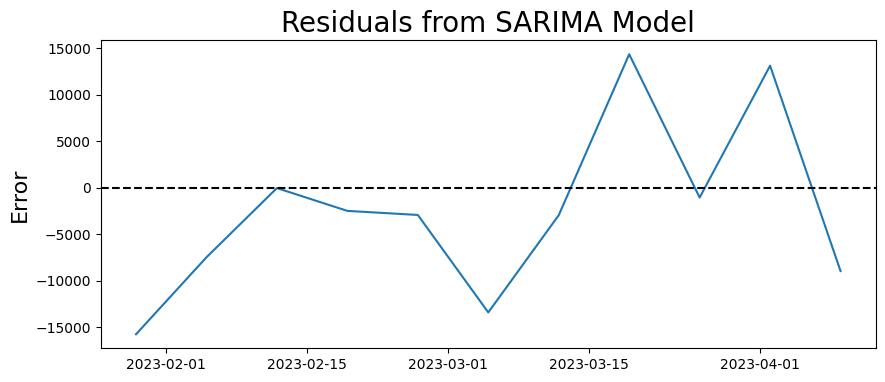

In [67]:
plt.figure(figsize=(10,4))
plt.plot(testing.index,sarima_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

The residuals show a pattern where our predicted model has the tendency to slightly over-value our testing data compared to under-valuing it. 

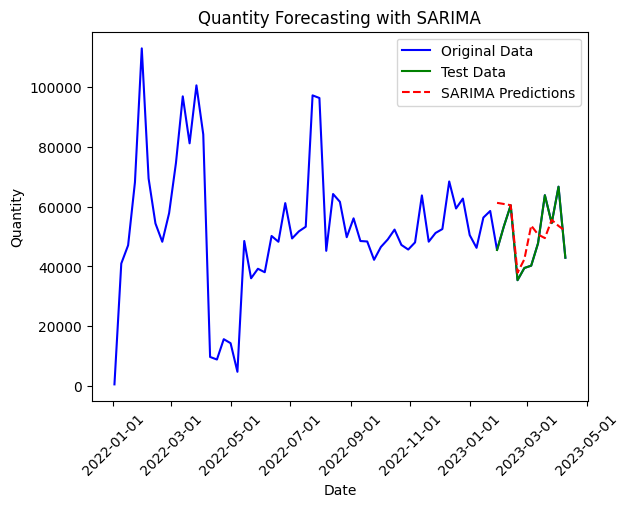

In [68]:
# Convert the index of data to datetime objects
date_index = data.index

# Plot the original data
plt.plot(date_index, data["quantity"], label="Original Data", color="blue")

# Plot the test data
test_start = len(train_data)
test_end = len(data)
plt.plot(date_index[test_start:], test_data["quantity"], label="Test Data", color="green")

# Plot the SARIMA predictions
plt.plot(date_index[test_start:], sarima_pred_values, label="SARIMA Predictions", color="red", linestyle="--")

# Customize the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Added to fix the x-axis date ticks
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Quantity Forecasting with SARIMA")
plt.legend()
plt.show()

#### Metric Comparison Between The 3 Models

In [69]:
print(f"NeuralProphet Mean Absolute Error: {neural_prophet_mae}")
print(f"NeuralProphet Mean Absolute Percentage Error: {neural_prophet_mape*100}","%")
print('------------------------')
print(f"LSTM Mean Absolute Error: {lstm_mae}")
print(f"LSTM Mean Absolute Percentage Error: {lstm_mape*100}","%")
print('-----------------------')
print(f"SARIMA Mean Absolute Error: {sarima_mae}")
print(f"SARIMA Mean Absolute Percentage Error: {sarima_mape*100}","%")

NeuralProphet Mean Absolute Error: 8856.84765625
NeuralProphet Mean Absolute Percentage Error: 20.48436560025533 %
------------------------
LSTM Mean Absolute Error: 9434.677455357143
LSTM Mean Absolute Percentage Error: 17.579643233457958 %
-----------------------
SARIMA Mean Absolute Error: 7510.290886043071
SARIMA Mean Absolute Percentage Error: 15.250196958841562 %


We can see from the comparison above, that the LSTM has a higher MAE score but a lower MAPE score. This is because of a slight difference in the scale of the prediction (LSTM test set is only for the last 7 data). Which is why for our evaluation, we will be mainly focusing on the Mean Absolute Percentage Score (MAPE).

In this specific case, the SARIMA model edges out the other models because it effectively models the linear relationships, trends, and seasonality present in the data. The data's characteristics may be more suited for the SARIMA model, leading to better forecasting accuracy. On the other hand, the LSTM and NeuralProphet models might require more complex relationships and features in the data to show their true potential. Additionally, the SARIMA model has the advantage of being more interpretable, which can be valuable for understanding the underlying patterns in the data and making informed decisions.

#### Comparison of Residuals

We will compare the residuals of each model, in order to compare the tendencies of each model. By looking at the residuals, we can see if our model has a tendency to over-value our quantity sales or under-valuing it.

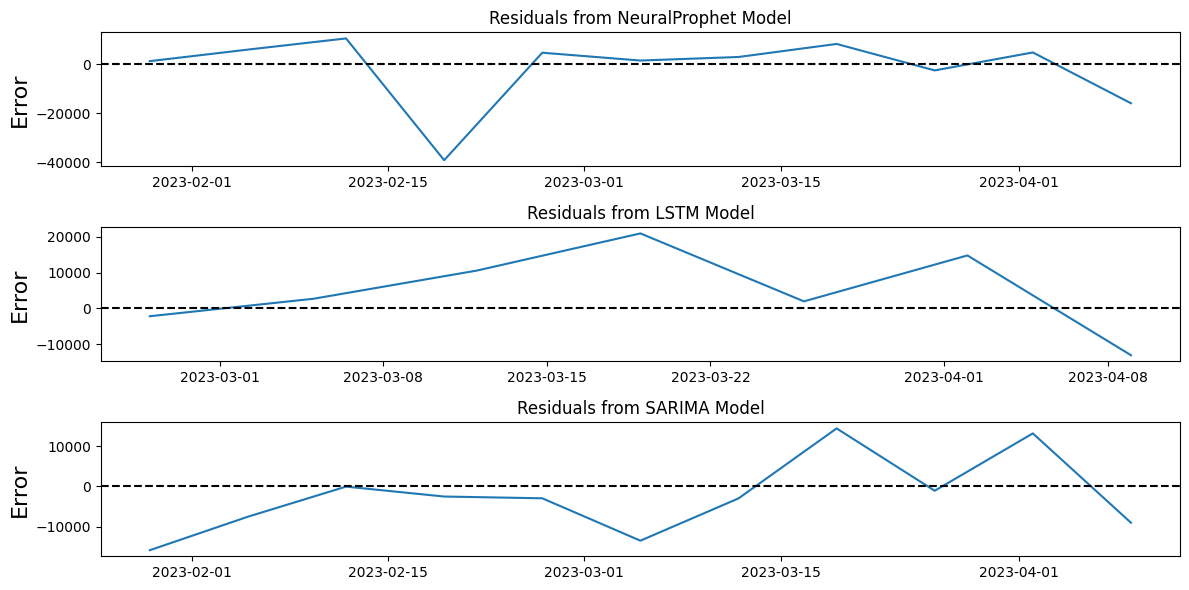

In [70]:
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(testing.index,residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from NeuralProphet Model')
plt.ylabel('Error', fontsize=16)

plt.subplot(3, 1, 2)
plt.plot(lstm_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from LSTM Model')
plt.ylabel('Error', fontsize=16)

plt.subplot(3, 1, 3)
plt.plot(testing.index,sarima_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model')
plt.ylabel('Error', fontsize=16)

plt.tight_layout()
plt.show()

As explained before, a negative error score means that the predicted value is over-valuing and a positive error means that the predicted value is under-valuing the test data.

Before we compare the the residuals of the three models, it is best we understand first which model is better for our case? Is it a model that over-values our data? Or is it a model that under-values it?

Firstly, we need to consider the consequences of each tendencies:
1.	If over-predicting the amount of items sold has more severe consequences, such as overstocking inventory, increased holding costs, or spoilage for perishable items, we might want to choose the model that predicts a lower amount. This way, we are more likely to avoid these negative consequences.
2.	Conversely, if under-predicting the amount of items sold has more severe consequences, such as stockouts, lost sales, and customer dissatisfaction, we might want to choose the model that predicts a higher amount. This way, we can ensure we have enough inventory to meet demand.


In [71]:
print('Mean of Quantity Sales of the Total Data (All Products)\n',df['quantity'].mean())
print('Mean of Quantity Sales of the Selected Product\n',prod_count['quantity'].mean())

Mean of Quantity Sales of the Total Data (All Products)
 3191.6219641588227
Mean of Quantity Sales of the Selected Product
 52729.850746268654


The code above shows us that our product has a massively higher quantity sales compared to the average quantity sales of our other products that are on our dataset. This suggests that the our selected product is very popular and has a strong demand. It could be due to various factors such as effective marketing, brand reputation, product quality, or a combination of these factors.

Hence why in my personal opinion, given the high demand for the product, I would lean towards preferring an over-predicting model. The reasoning behind this is that under-predicting the sales could lead to stockouts and lost sales opportunities, which could ultimately result in customer dissatisfaction and negatively impact the company's reputation.

An over-predicting model might lead to a higher inventory level, but in the case of a high-demand product, the risks associated with holding excess inventory are likely to be lower than the risks of stockouts. Of course, it's essential to find a balance and not overstock to an extreme level that would lead to significantly increased holding costs or spoilage (if the product has a limited shelf life). In the end however, the key is to find an optimal balance between inventory levels and demand to maximize profits and customer satisfaction.

Which is why for our case, after considering the metrics and the preferred choice of over-valuing predictions from our models, we can conclude that our SARIMA model is the best fit for predicting or forecasting future data, due to the models lower error values and its tendency to over-value our data compared to our other models.

## Forecasting Using Best Model

Since we have concluded that our SARIMA model is the best for our use case, we will now predict the future quantity item sales for 12 periods (12 weeks).

In [72]:
# Create a new index for the forecasted series
num_predictions = 12
last_date = data.index[-1]
forecast_index = [last_date + DateOffset(weeks=x) for x in range(1, num_predictions + 1)]

# Forecast the data
forecast = sarima_results.forecast(steps=num_predictions)

# Set the new index for the forecasted series
forecast_series = pd.Series(forecast.values, index=forecast_index)


In [73]:
forecast_series

2023-04-16    61279.498278
2023-04-23    60905.690006
2023-04-30    60492.629728
2023-05-07    37895.514788
2023-05-14    42414.224749
2023-05-21    53679.815247
2023-05-28    50695.273256
2023-06-04    49486.375529
2023-06-11    55562.721215
2023-06-18    53555.340379
2023-06-25    51890.548387
2023-07-02    52033.084923
dtype: float64

In [74]:
combined_data = pd.concat([data, forecast_series])

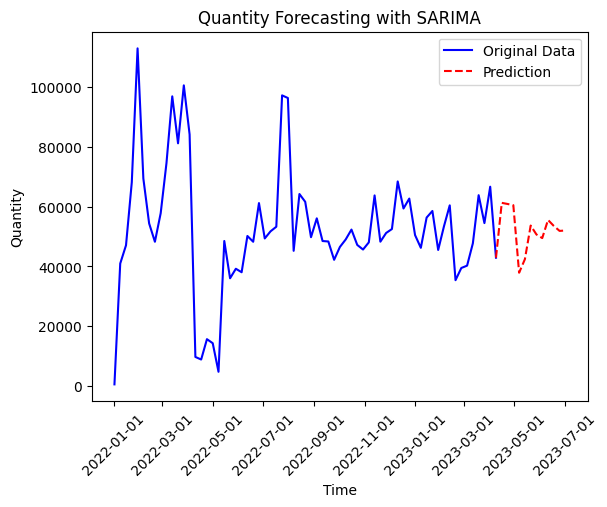

In [75]:
# Create a combined index for the plot
combined_index = data.index.append(forecast_series.index)

# Plot the original data
plt.plot(combined_index[:len(data)], data["quantity"], label="Original Data", color="blue")

# Add the future predictions as a separate line segment
extended_data = np.concatenate((data["quantity"].values[-1:], forecast_series))
plt.plot(combined_index[len(data) - 1:], extended_data, label="Prediction", color="red", linestyle="--")

# Customize the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Quantity")
plt.title("Quantity Forecasting with SARIMA")
plt.legend()
plt.show()

We can see from the above visualization that our SARIMA model managed to understand the seasonality pattern of our data, with a constant trend that is not decreasing or increasing. However, if our real future values were to have an unexpected increase or decrease on a large scale, our SARIMA model can have trouble predicting it.

## Recommendations for Further Improvements

There are a couple of things that can be done to improve our models accuracy:

1. More variety in our hyperparameter tuning: The models tested in this notebook have been done with a variety of parameters, however they were done manually which results in our hyperparameter search not having much variety which results in possible missed opportunities for better accuracy models. We can try using a gridsearch on our models to search for more parameters that may increase our accuracy.

2. Increase the amount of data: Since the data is recorded on a weekly basis instead of a daily basis, and the data only having 67 weeks worth of data, this results in us having to model our time series using very limited amount of data. However, since acquiring new datas can be expensive, we don't need to go overboard with the addition of new datas. In my personal opinion, I believe at least 2-3 cycles worth of yearly data (104-156) could help us in increasing our prediction accuracy and better forecasts, since those extra data can help in determining if our data has any seasonality that can be noticed more with the help of the extra data. 

3. Use other models: There may be other models that are more suited for this particular task, such as Bayesian Structural Time Series, Exponential Smoothing State Space Model, or GRU Neural Networks.

## Conclusion

Based on all of the analysis that we have done, we can conclude the following:

- Our timeseries data for the product item that we analyze is stationary with no trends, but have a possible seasonality cycle of 10.

- To predict the time series, we use three different models (LSTM, NeuralProphet, SARIMA) with SARIMA having the lowest Mean Absolute Percentage Error (15.25%).

- We can improve the model by either increasing our data set to at least 2 yearly cycles, using more parameter variance during our model tuning or experimenting with other models.

- Our forecasted model for the next 3 months is able to capture the seasonality of our original dataset but may struggle if it has to predict a sharp drop or increase in quantity sales.